# Forecasting Walmart Sales

This project builds a machine learning model to predict Walmart's weekly sales using historical data, store details, holidays, and economic factors. It focuses on data preprocessing, feature engineering, and model training to improve forecasting, with RMSE as the evaluation metric.

## Installing Dependencies

In [9]:
pip install numpy pandas matplotlib seaborn statsmodels tqdm scikit-learn prophet tensorflow statsmodels prophet tensorflow;

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.stattools import adfuller 
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings

warnings.filterwarnings("ignore")


## Import Data

In [4]:
train_df = pd.read_csv('Data/train.csv')
train_df.rename(columns={'Sales(In ThousandDollars)': 'Sales'}, inplace=True)
train_df

,Year,Month,ProductCategory,Sales
0,2009,1,WomenClothing,1755.0
1,2009,1,MenClothing,524.0
2,2009,1,OtherClothing,936.0
3,2009,2,WomenClothing,1729.0
4,2009,2,MenClothing,496.0
...,...,...,...,...
175,2013,11,MenClothing,798.0
176,2013,11,OtherClothing,1209.0
177,2013,12,WomenClothing,4865.0
178,2013,12,MenClothing,1085.0


In [3]:
# Combine year and month into a datetime column representing the end of the month

train_df['Date'] = pd.to_datetime(train_df[['Year', 'Month']].assign(day=1)) + pd.offsets.MonthEnd(1)

In [4]:
train_df.head()

,Year,Month,ProductCategory,Sales,Date
0,2009,1,WomenClothing,1755.0,2009-01-31
1,2009,1,MenClothing,524.0,2009-01-31
2,2009,1,OtherClothing,936.0,2009-01-31
3,2009,2,WomenClothing,1729.0,2009-02-28
4,2009,2,MenClothing,496.0,2009-02-28


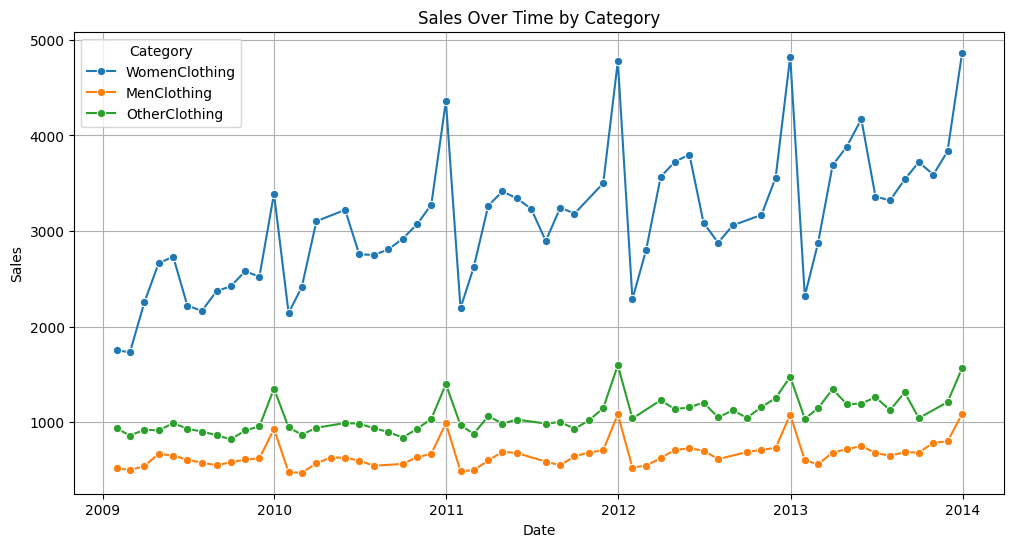

In [5]:
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_df, x='Date', y='Sales', hue='ProductCategory', marker='o')

plt.title('Sales Over Time by Category')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(title='Category')
plt.grid(True)
plt.show()

**Notes from the Plot:**

1. **Sales Trends by Category:**

    WomenClothing: This category shows a significant upward trend over time with notable peaks around the end of each year, indicating a seasonal pattern. Sales generally increase towards the end of each year, likely due to holiday shopping.
    MenClothing: This category shows a relatively stable trend with slight fluctuations. There are small peaks around the end of each year, but the overall sales are much lower than WomenClothing.
    OtherClothing: This category also shows a stable trend similar to MenClothing, with occasional spikes towards the end of each year.

2. **Sales Magnitude:**

    WomenClothing consistently has the highest sales compared to the other two categories. The sales values for WomenClothing range between 2000 and 5000.
    MenClothing and OtherClothing have lower sales values, mostly under 1000, with MenClothing slightly lower than OtherClothing.

3. **Seasonal Peaks:**

    All categories show spikes around the end of each year. This suggests that there might be seasonal events, such as holidays, that drive up sales during these periods.

## Data Preprocessing

In [ ]:
# Create a copy of the training dataframe

train_arima_df = train_df.copy()

### Split the data by product category

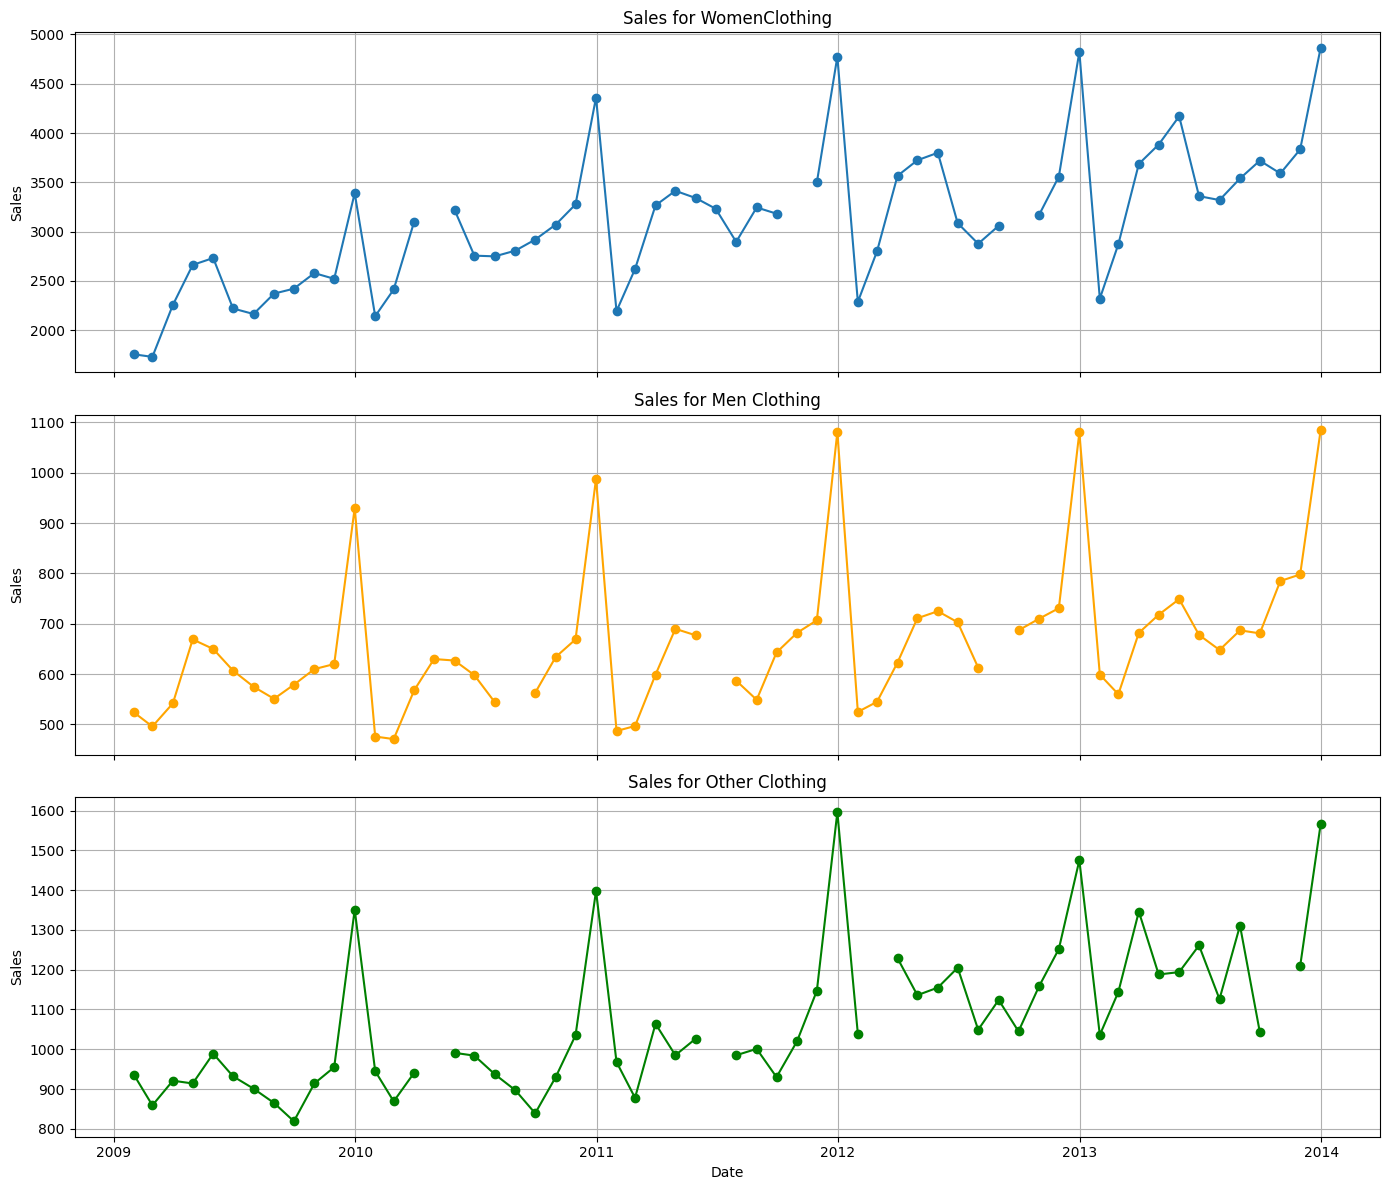

In [ ]:
# Split the dataframe by ProductCategory and subset only the 'Sales' and 'Date' columns
df_women = train_arima_df[train_arima_df['ProductCategory'] == 'WomenClothing'][['Date', 'Sales']].set_index('Date')
df_men = train_arima_df[train_arima_df['ProductCategory'] == 'MenClothing'][['Date', 'Sales']].set_index('Date')
df_other = train_arima_df[train_arima_df['ProductCategory'] == 'OtherClothing'][['Date', 'Sales']].set_index('Date')

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot each ProductCategory
axes[0].plot(df_women.index, df_women['Sales'], marker='o', label='WomenClothing')
axes[0].set_title('Sales for WomenClothing')
axes[0].set_ylabel('Sales')
axes[0].grid(True)

axes[1].plot(df_men.index, df_men['Sales'], marker='o', color='orange', label='MenClothing')
axes[1].set_title('Sales for Men Clothing')
axes[1].set_ylabel('Sales')
axes[1].grid(True)

axes[2].plot(df_other.index, df_other['Sales'], marker='o', color='green', label='OtherClothing')
axes[2].set_title('Sales for Other Clothing')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Sales')
axes[2].grid(True)

plt.tight_layout()
plt.show()

We can see that every category has some missing data, will use Interpolation to fill in the missing values

Interpolation: Fill missing values using interpolation, which estimates missing values by assuming a linear relationship between neighboring points.

### Handling Missing Values

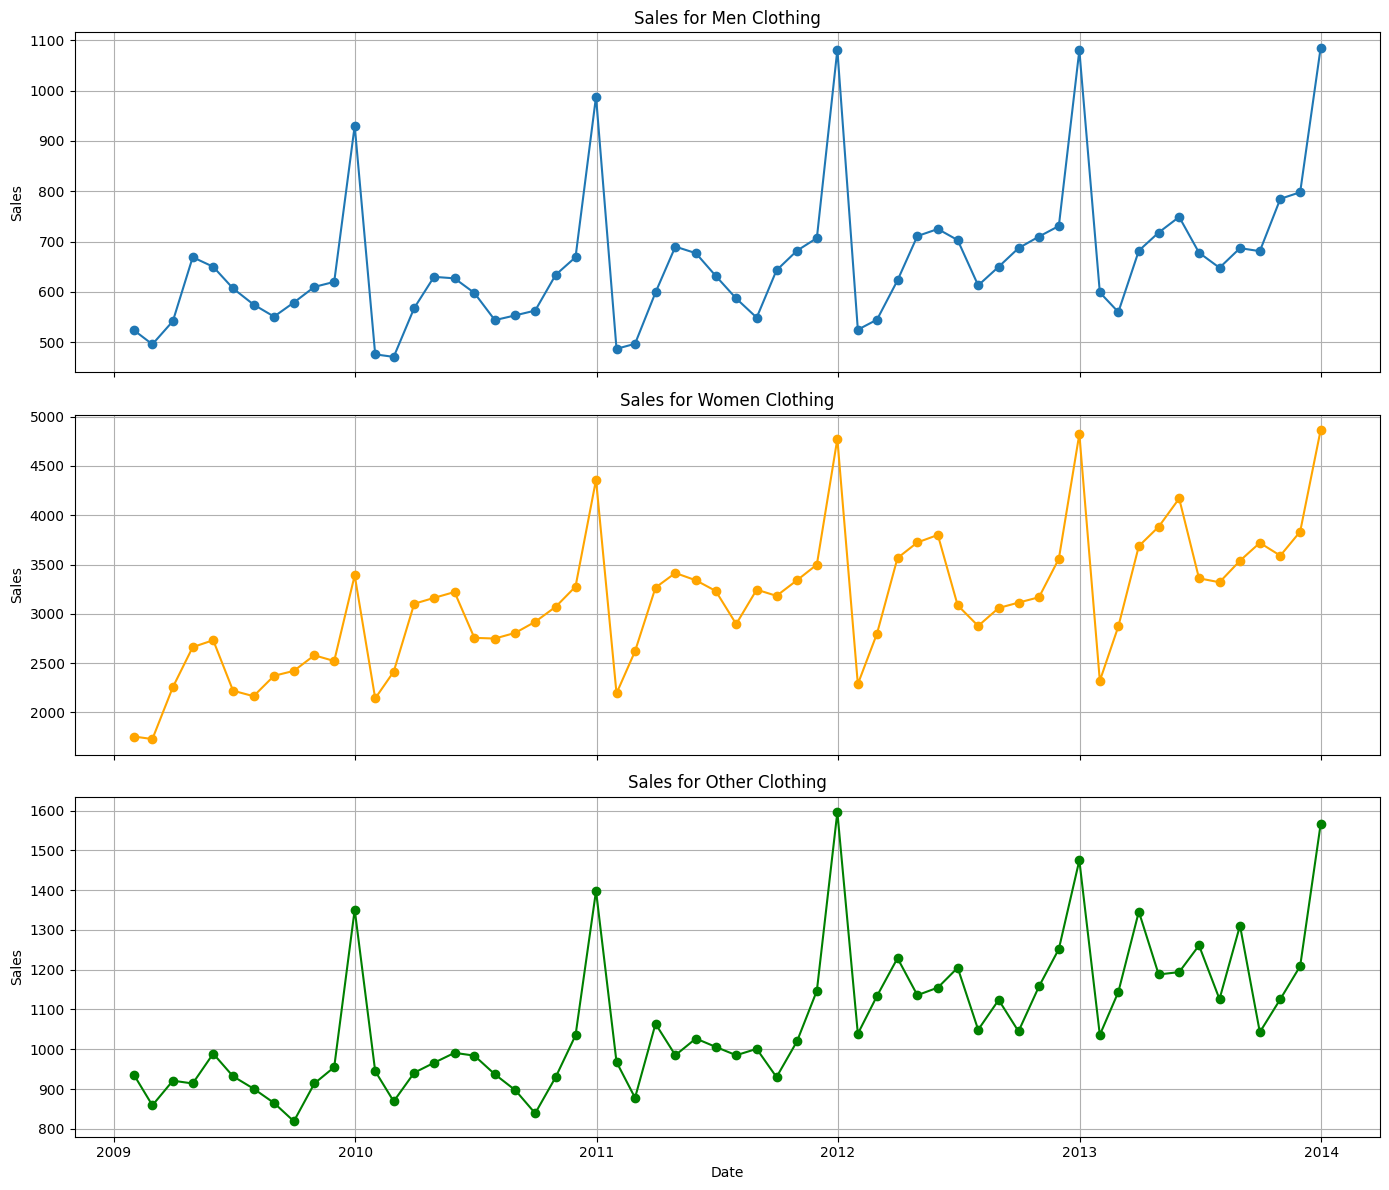

In [ ]:
# Handle missing values with interpolatation
df_men['Sales'] = df_men['Sales'].interpolate()
df_women['Sales'] = df_women['Sales'].interpolate()
df_other['Sales'] = df_other['Sales'].interpolate()

# Create subplots for interpolation
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot each ProductCategory with interpolated values
axes[0].plot(df_men.index, df_men['Sales'], marker='o', label='Men Clothing')
axes[0].set_title('Sales for Men Clothing')
axes[0].set_ylabel('Sales')
axes[0].grid(True)

axes[1].plot(df_women.index, df_women['Sales'], marker='o', color='orange', label='Women Clothing')
axes[1].set_title('Sales for Women Clothing')
axes[1].set_ylabel('Sales')
axes[1].grid(True)

axes[2].plot(df_other.index, df_other['Sales'], marker='o', color='green', label='Other Clothing')
axes[2].set_title('Sales for Other Clothing')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Sales')
axes[2].grid(True)

plt.tight_layout()
plt.show()

### Test for Stationarity

In [ ]:
def test_stationarity(df, column, title):
    """
    Perform the Augmented Dickey-Fuller test to check the stationarity of a time series.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the time series data.
    column (str): The name of the column containing the time series data.
    title (str): The title/name of the DataFrame.
    
    Returns:
    None: Prints the test results along with the DataFrame title.
    """
    print(f'Testing stationarity for {title}...')
    
    # Perform ADF test
    result = adfuller(df[column].dropna())
    
    # Extract and format the results
    adf_statistic = result[0]
    p_value = result[1]
    used_lag = result[2]
    n_obs = result[3]
    critical_values = result[4]
    
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print(f'Number of Lags Used: {used_lag}')
    print(f'Number of Observations Used: {n_obs}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')
    
    # Determine stationarity based on the p-value
    if p_value < 0.05:
        print(f"{title} time series is stationary (reject null hypothesis)")
    else:
        print(f"{title} time series is not stationary (fail to reject null hypothesis)")
    print()


In [ ]:
# Perform the ADF test

# Dictionary of DataFrames with titles
dfs = {
    'df_men': df_men,
    'df_women': df_women,
    'df_other': df_other
}

# Loop over DataFrames and test stationarity using tqdm for progress bar
for title, df in tqdm(dfs.items()):
    test_stationarity(df, 'Sales', title)

100%|██████████| 3/3 [00:00<00:00, 320.66it/s]

Testing stationarity for df_men...
ADF Statistic: 1.520129864635399
p-value: 0.997597027617428
Number of Lags Used: 11
Number of Observations Used: 48
Critical Values:
   1%: -3.5745892596209488
   5%: -2.9239543084490744
   10%: -2.6000391840277777
df_men time series is not stationary (fail to reject null hypothesis)

Testing stationarity for df_women...
ADF Statistic: -2.9426914260877273
p-value: 0.04060404609414759
Number of Lags Used: 11
Number of Observations Used: 48
Critical Values:
   1%: -3.5745892596209488
   5%: -2.9239543084490744
   10%: -2.6000391840277777
df_women time series is stationary (reject null hypothesis)

Testing stationarity for df_other...
ADF Statistic: 0.5326892652337949
p-value: 0.9858335146323536
Number of Lags Used: 11
Number of Observations Used: 48
Critical Values:
   1%: -3.5745892596209488
   5%: -2.9239543084490744
   10%: -2.6000391840277777
df_other time series is not stationary (fail to reject null hypothesis)



The only stationary timeseries is the women's. We will need to perform differencing on the other two timeseries, we will also perform differencing on the women's dataset to improve model prediction performance.

In [ ]:
# First-order differencing

df_men['Sales_diff'] = df_men['Sales'].diff()
df_women['Sales_diff'] = df_women['Sales'].diff()
df_other['Sales_diff'] = df_other['Sales'].diff()

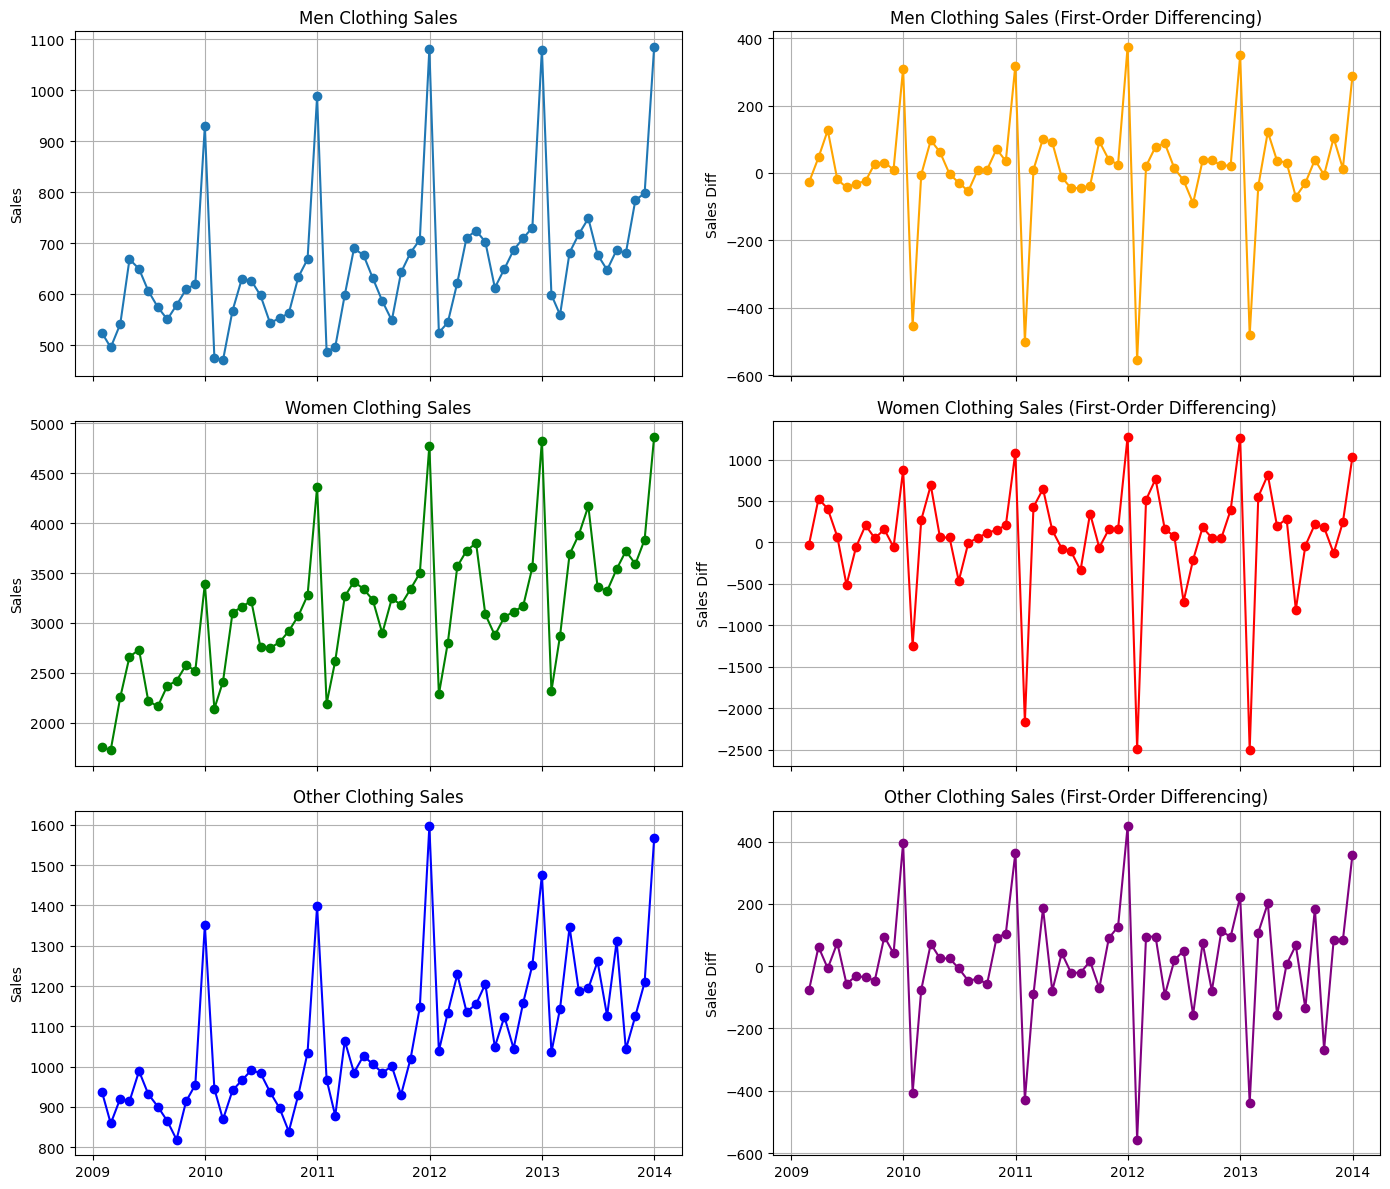

In [ ]:
# Create subplots after differencing
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True)

# Plot original and differenced series for df_men_interpolated
axes[0, 0].plot(df_men.index, df_men['Sales'], marker='o')
axes[0, 0].set_title('Men Clothing Sales')
axes[0, 0].set_ylabel('Sales')
axes[0, 0].grid(True)

axes[0, 1].plot(df_men.index, df_men['Sales_diff'], marker='o', color='orange')
axes[0, 1].set_title('Men Clothing Sales (First-Order Differencing)')
axes[0, 1].set_ylabel('Sales Diff')
axes[0, 1].grid(True)

# Plot original and differenced series for df_women_interpolated
axes[1, 0].plot(df_women.index, df_women['Sales'], marker='o', color='green')
axes[1, 0].set_title('Women Clothing Sales')
axes[1, 0].set_ylabel('Sales')
axes[1, 0].grid(True)

axes[1, 1].plot(df_women.index, df_women['Sales_diff'], marker='o', color='red')
axes[1, 1].set_title('Women Clothing Sales (First-Order Differencing)')
axes[1, 1].set_ylabel('Sales Diff')
axes[1, 1].grid(True)

# Plot original and differenced series for df_other_interpolated
axes[2, 0].plot(df_other.index, df_other['Sales'], marker='o', color='blue')
axes[2, 0].set_title('Other Clothing Sales')
axes[2, 0].set_ylabel('Sales')
axes[2, 0].grid(True)

axes[2, 1].plot(df_other.index, df_other['Sales_diff'], marker='o', color='purple')
axes[2, 1].set_title('Other Clothing Sales (First-Order Differencing)')
axes[2, 1].set_ylabel('Sales Diff')
axes[2, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Perform the ADF test again

# Dictionary of DataFrames with titles
dfs = {
    'df_men': df_men,
    'df_other': df_other
}

# Loop over DataFrames and test stationarity using tqdm for progress bar
for title, df in tqdm(dfs.items(), desc='Testing stationarity'):
    test_stationarity(df, 'Sales_diff', title)

Testing stationarity: 100%|██████████| 2/2 [00:00<00:00, 342.59it/s]

Testing stationarity for df_men...
ADF Statistic: -4.483029490388699
p-value: 0.0002110001788536388
Number of Lags Used: 11
Number of Observations Used: 47
Critical Values:
   1%: -3.5778480370438146
   5%: -2.925338105429433
   10%: -2.6007735310095064
df_men time series is stationary (reject null hypothesis)

Testing stationarity for df_other...
ADF Statistic: -3.429110057981133
p-value: 0.01000564670273675
Number of Lags Used: 11
Number of Observations Used: 47
Critical Values:
   1%: -3.5778480370438146
   5%: -2.925338105429433
   10%: -2.6007735310095064
df_other time series is stationary (reject null hypothesis)



All three timeseries are now stationary, we can move forward with training the ARIMA model. **One thing to note is that we will need to invert the differencing to convert the forecasts back to the original scale.**  

## SARIMA Model

* The Seasonal ARIMA model is a univariate model focused on analyzing and forecasting a single time series, meaning that it can't take any additional inpdependent variables
* The ARIMA model can't handle missing values, data preprocessing is required 
* The ARIMA model requires stationary time series, meaning that the statistical properties of the time series, such as the mean, variance, and autocorrelation, remain constant over time

### Model Training and Forecasting

In [129]:
def run_sarima_model(df, sales_column, differenced_column, order, seasonal_order, title, train_ratio=0.8):
    # Train-test split
    train_size = int(len(df) * train_ratio)
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    
    # Fit SARIMA model on the differenced column
    model = SARIMAX(train[differenced_column], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    
    # Forecast on the differenced column
    n_forecasts = len(test)
    forecast = model_fit.get_forecast(steps=n_forecasts)
    forecast_index = test.index
    forecast_values = forecast.predicted_mean
    
    # Combine the original and forecasted values
    combined_df = pd.concat([train, test])
    combined_df['Forecast_diff'] = np.nan
    combined_df.loc[forecast_index, 'Forecast_diff'] = forecast_values
    
    # Create a new column for the inverted forecast (invert differencing)
    combined_df['Forecast_inverted'] = np.nan

    # Find the last actual sales value before the forecast period
    last_actual_sales_index = combined_df[sales_column].last_valid_index()
    last_actual_sales_value = combined_df.loc[last_actual_sales_index, sales_column]

    # Start inverting the forecast from the first forecasted value
    forecast_started = False
    for idx, row in combined_df.iterrows():
        if pd.notna(row['Forecast_diff']):
            if not forecast_started:
                previous_value = last_actual_sales_value
                forecast_started = True
            else:
                previous_value = combined_df.loc[previous_idx, 'Forecast_inverted']
            
            combined_df.at[idx, 'Forecast_inverted'] = previous_value + row['Forecast_diff']
        previous_idx = idx
    
    # Ensure no NaN values in the forecasted period
    forecast_values = combined_df.loc[forecast_index, 'Forecast_inverted'].dropna()
    actual_values = test[sales_column].loc[forecast_values.index]
    
    # Calculate error metrics
    mae = mean_absolute_error(actual_values, forecast_values)
    mse = mean_squared_error(actual_values, forecast_values)
    mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100
    
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(combined_df.index, combined_df[sales_column], label='Original Series')
    plt.plot(combined_df.index, combined_df['Forecast_inverted'], label='Forecast', color='red')
    plt.axvline(x=train.index[-1], color='gray', linestyle='--', label='Train-Test Split')
    plt.legend()
    plt.title(f'Sales Forecasting for {title} with SARIMA')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid(True)
    plt.show()
    
    return combined_df

Mean Absolute Error (MAE): 28.064549525654467
Mean Squared Error (MSE): 975.9479129361275
Mean Absolute Percentage Error (MAPE): 3.90%


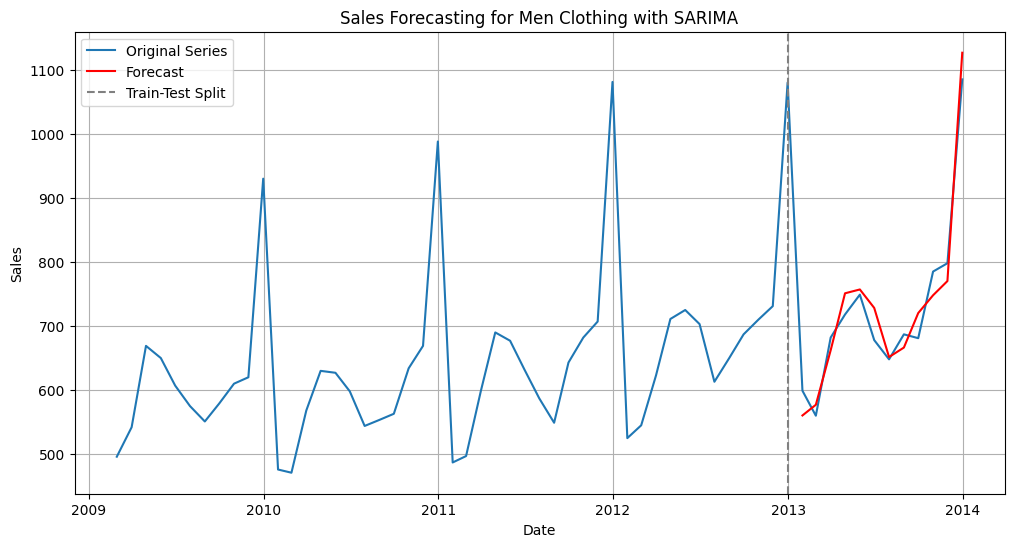

Mean Absolute Error (MAE): 244.2048374491229
Mean Squared Error (MSE): 95671.40621087136
Mean Absolute Percentage Error (MAPE): 6.75%


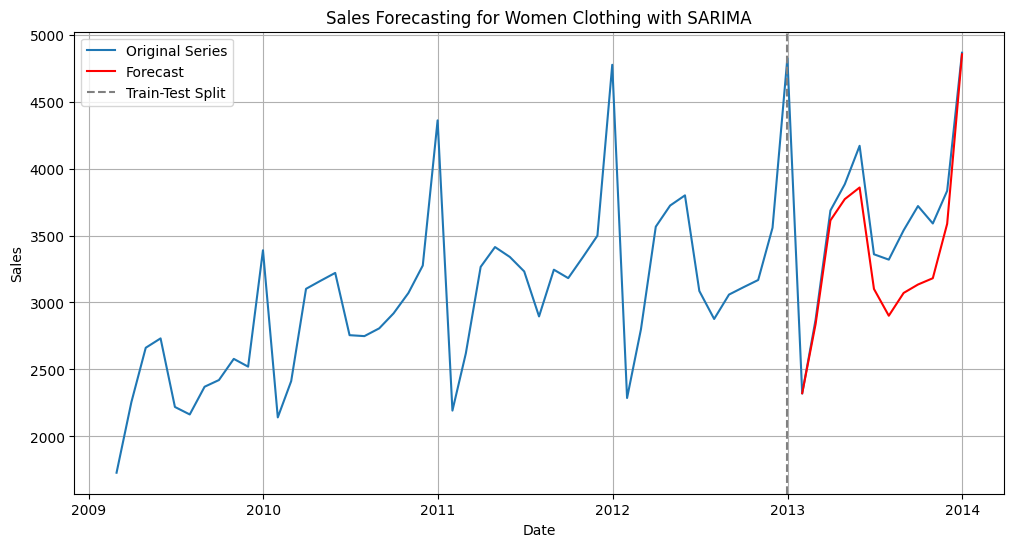

Mean Absolute Error (MAE): 92.71982803879096
Mean Squared Error (MSE): 11285.816267613083
Mean Absolute Percentage Error (MAPE): 7.92%


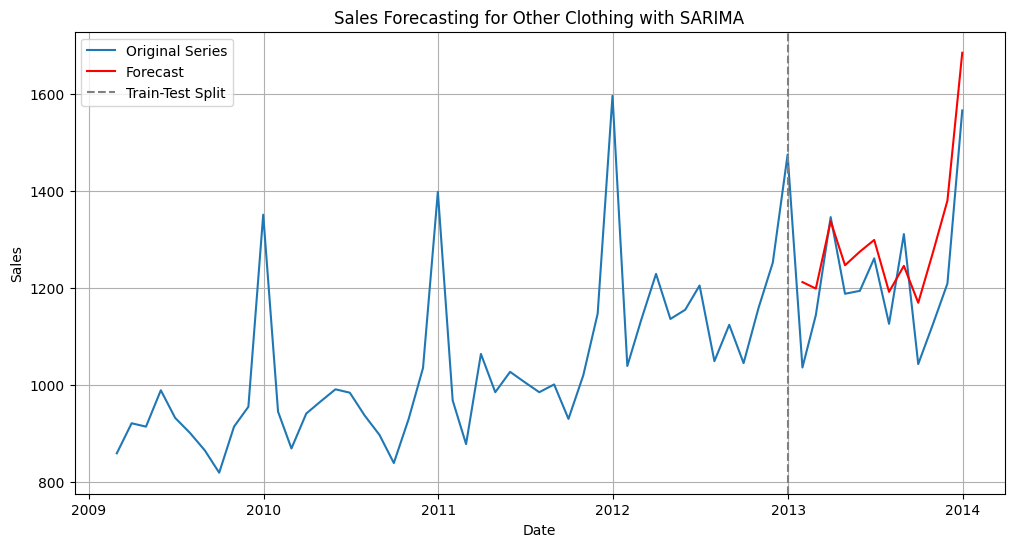

In [130]:
# Define the order and seasonal order parameters -- refer to "Improving the Forecast" section
order = (1, 0, 1)
seasonal_order = (1, 1, 0, 12)

# Run the forecasting 
df_forecast_men = run_sarima_model(df_men.dropna(), 'Sales', 'Sales_diff', order, seasonal_order, 'Men Clothing')
df_forecast_women = run_sarima_model(df_women.dropna(), 'Sales', 'Sales_diff', order, seasonal_order, 'Women Clothing')
df_forecast_other = run_sarima_model(df_other.dropna(), 'Sales', 'Sales_diff', order, seasonal_order, 'Other Clothing')

### Improving the Forecast

To improve the forecasting, we need to hypertune the order paramaters (p, d, q) and seasonal parameters (P, D, Q, s).

- Prior to training the model, we implemented first-order differening which means that d will remain to be 0.
- To better understand p and q, we will plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for the first-order differenced values then use them to draw a conclusion to the values of p and d. 
- We will also draw the ACF and PCF for the seasonal differenced values and use them to draw a conclusion fo the values of P, and Q.
- D is the seasonal differencing and this will remain to be 1 since we didn't do seasonal differncing prior to training the model.
- s will be 12 since a yearly seasonality is typically 12 months.

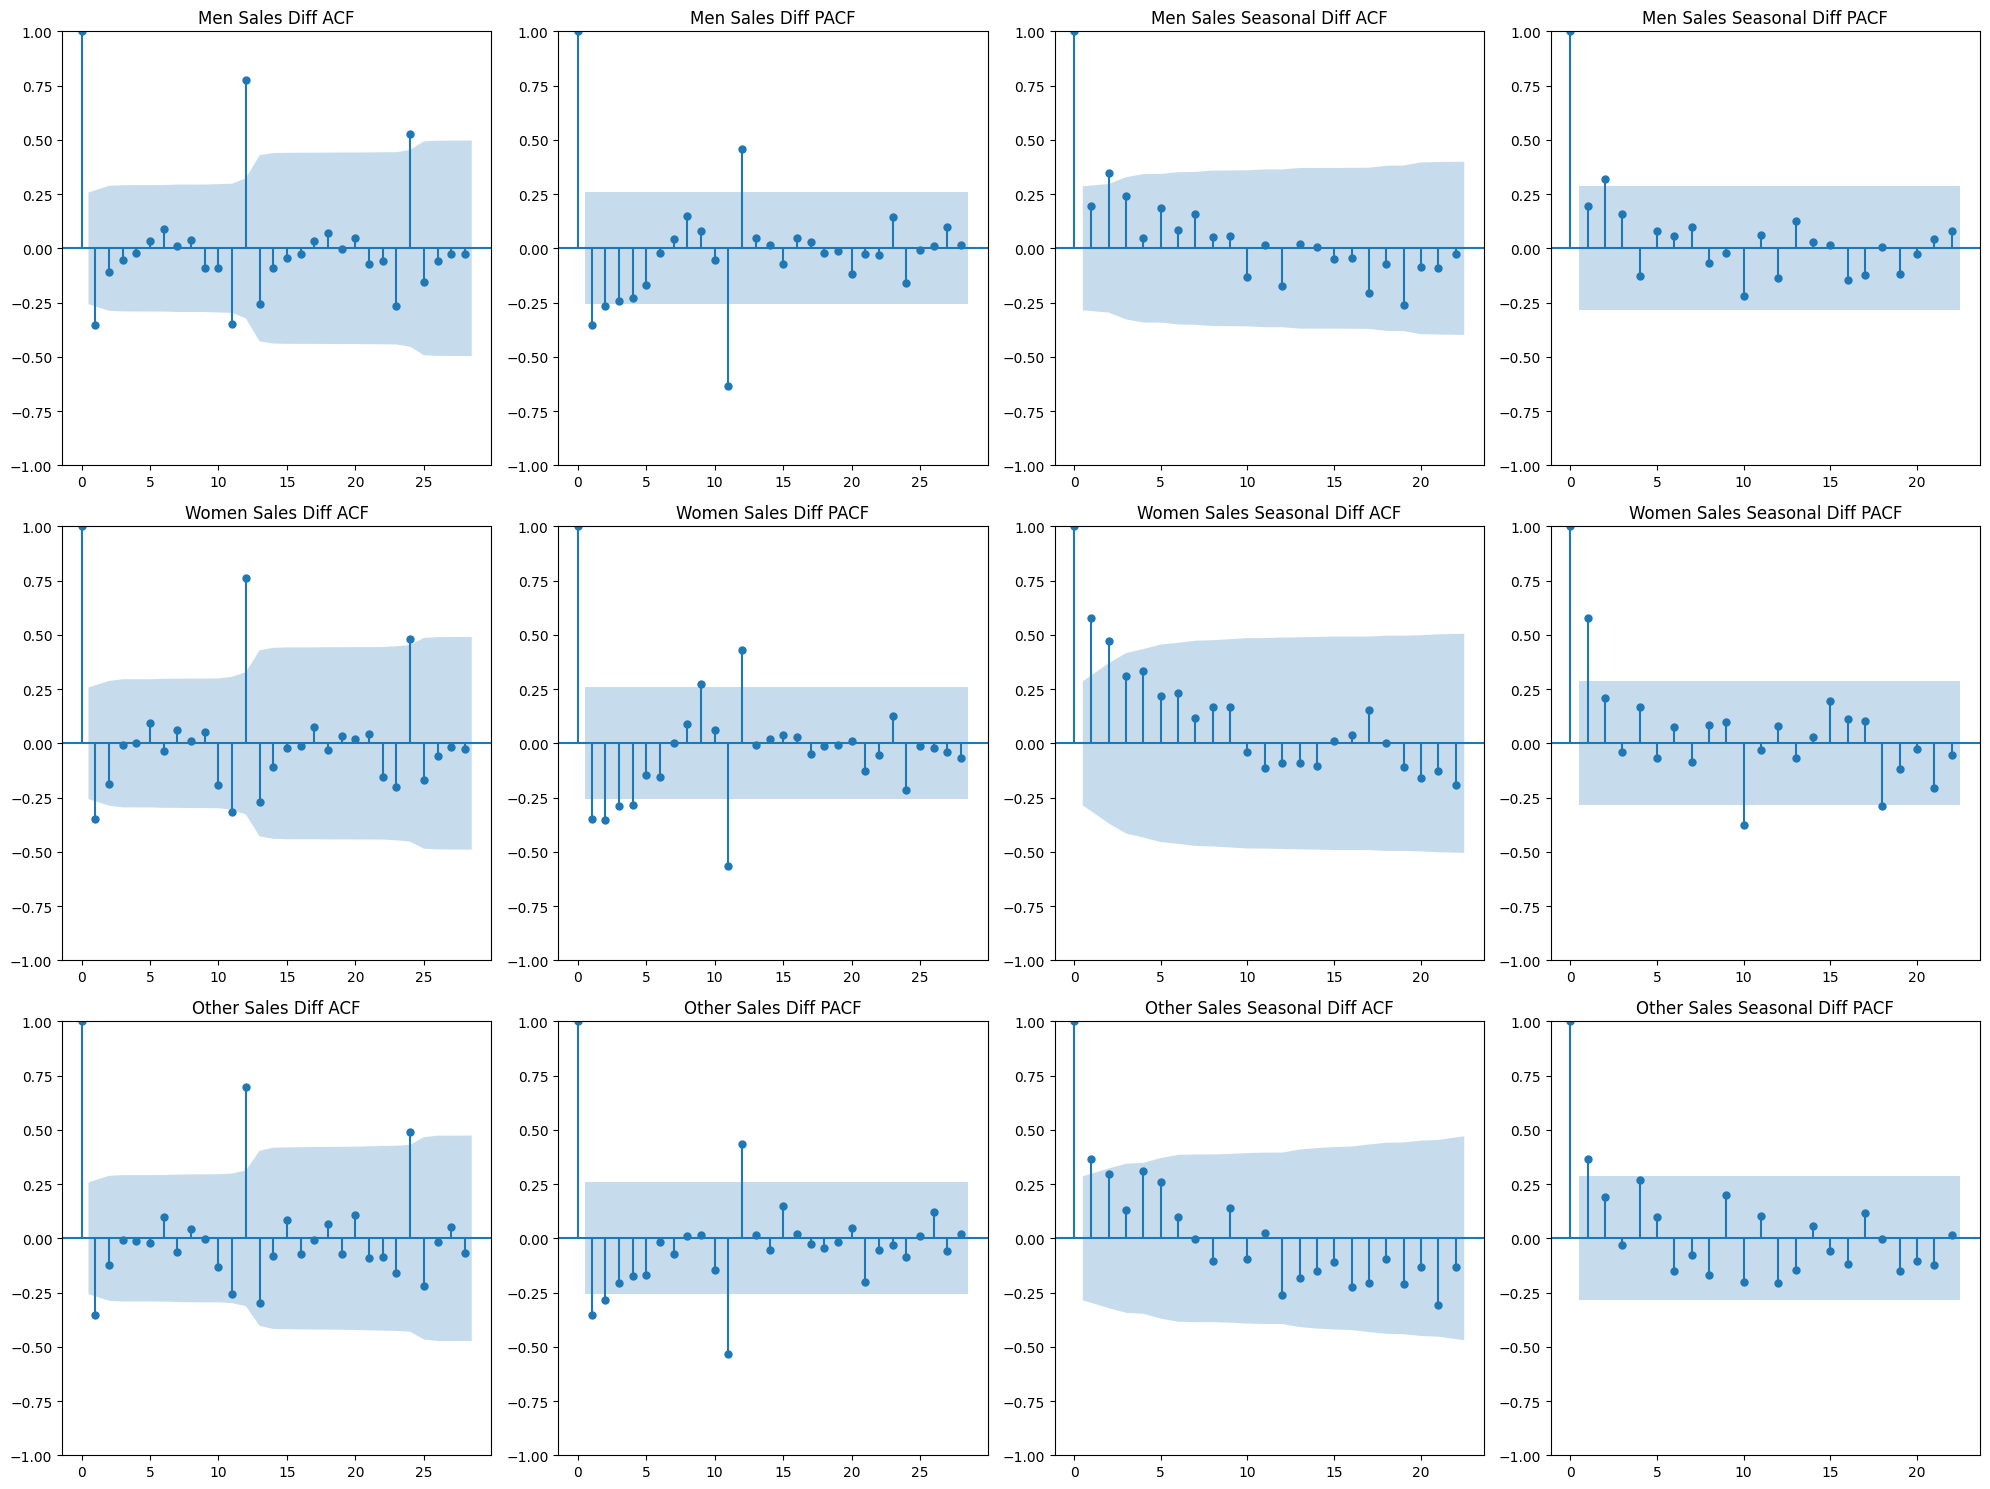

In [36]:
# Assuming df_forecast_men, df_forecast_women, and df_forecast_other are already defined
dataframes = {
    'Men': df_forecast_men,
    'Women': df_forecast_women,
    'Other': df_forecast_other
}

# Set up the figure and axes for subplots
fig, axes = plt.subplots(len(dataframes), 4, figsize=(20, 15))

# Loop through each dataframe and generate the plots
for i, (title, df) in enumerate(dataframes.items()):
    # Calculate differencing and seasonal differencing
    df['Sales_diff'] = df['Sales'].diff().dropna()
    df['Sales_seasonal_diff'] = df['Sales'].diff(12).dropna()
    
    # Plot ACF and PACF for the differenced data
    plot_acf(df['Sales_diff'].dropna(), lags=28, ax=axes[i, 0])
    axes[i, 0].set_title(f'{title} Sales Diff ACF')
    plot_pacf(df['Sales_diff'].dropna(), lags=28, ax=axes[i, 1])
    axes[i, 1].set_title(f'{title} Sales Diff PACF')
    
    # Plot ACF and PACF for the seasonal differenced data
    plot_acf(df['Sales_seasonal_diff'].dropna(), lags=22, ax=axes[i, 2])
    axes[i, 2].set_title(f'{title} Sales Seasonal Diff ACF')
    plot_pacf(df['Sales_seasonal_diff'].dropna(), lags=22, ax=axes[i, 3])
    axes[i, 3].set_title(f'{title} Sales Seasonal Diff PACF')

# Adjust layout
plt.tight_layout()
plt.show()

Interpreting ACF and PACF Plots:
**ACF Plot:**

The ACF plot shows significant spikes at lags 1, 2, and 11 across the board. This suggests potential autocorrelation up to lag 2 and a seasonal component at lag 11.

Non-seasonal MA (q): 1 (based on significant the highest spike in ACF at lag 1)

**PACF Plot:**

The PACF plot shows significant spikes at lags 1, and 11 across the board. This suggests potential partial autocorrelation up to lag 2 and a seasonal component at lag 11.

Non-seasonal AR (p): 1 (based on significant spike in PACF at lags)

Interpreting seaonsal ACF and PACF Plots:
**ACF Plot:**

The seasonal ACF plot shows significant spikes at lags 1, 2, and possibly around lag 11. This suggests potential seasonal autocorrelation at these lags.

Seasonal MA (Q): 1 (based on significant spikes in ACF at lag 1 and possibly 11) but we will define it as 0 as better results are achieved as there is only 48 months of training data and that may not exhibit a clear seasonal moving average pattern.

**PACF Plot:**

The seasonal PACF plot shows significant spikes at lag 1 and possibly around lag 11. This suggests potential seasonal partial autocorrelation at these lags.

Seasonal AR (P): 1 (based on significant spikes in PACF at lag 1 and possibly 11)

## Exponential Smoothing Model

Exponential smoothing methods, including Holt-Winters Exponential Smoothing, do not require differencing. These methods are designed to handle trends and seasonality directly through their internal components without the need for explicit differencing as is necessary in ARIMA models. Therefore, we will use the Sales column to train the model.

Mean Absolute Error (MAE): 25.696896793955876
Mean Squared Error (MSE): 777.8564105992056
Mean Absolute Percentage Error (MAPE): 3.62%


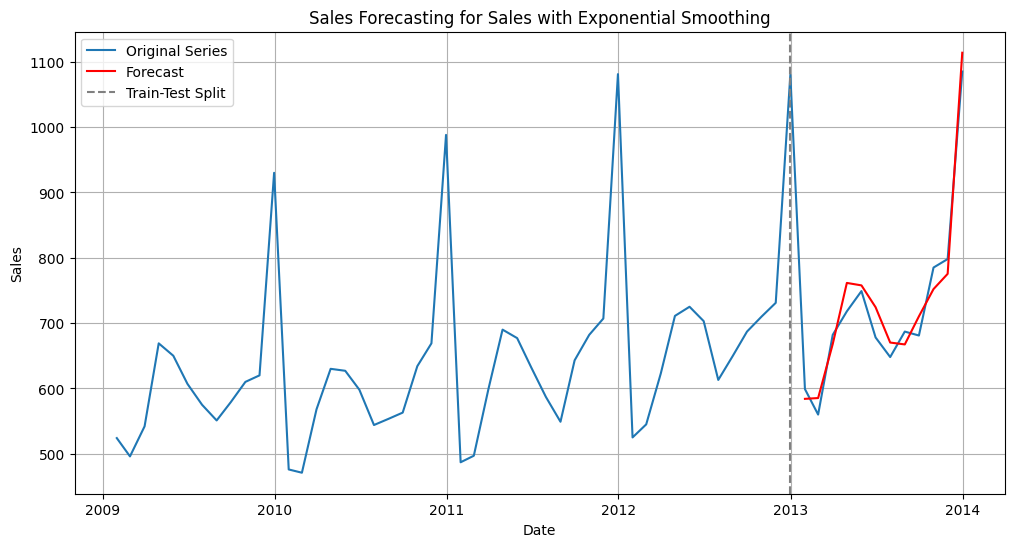

Mean Absolute Error (MAE): 120.96596952610419
Mean Squared Error (MSE): 28184.11489092663
Mean Absolute Percentage Error (MAPE): 3.78%


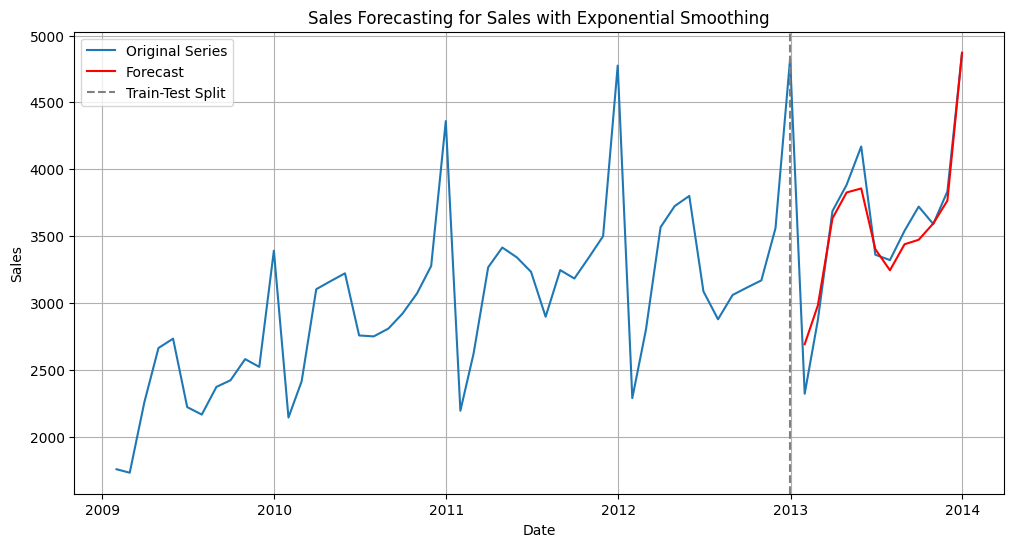

Mean Absolute Error (MAE): 62.88839839980651
Mean Squared Error (MSE): 6311.963856103831
Mean Absolute Percentage Error (MAPE): 5.11%


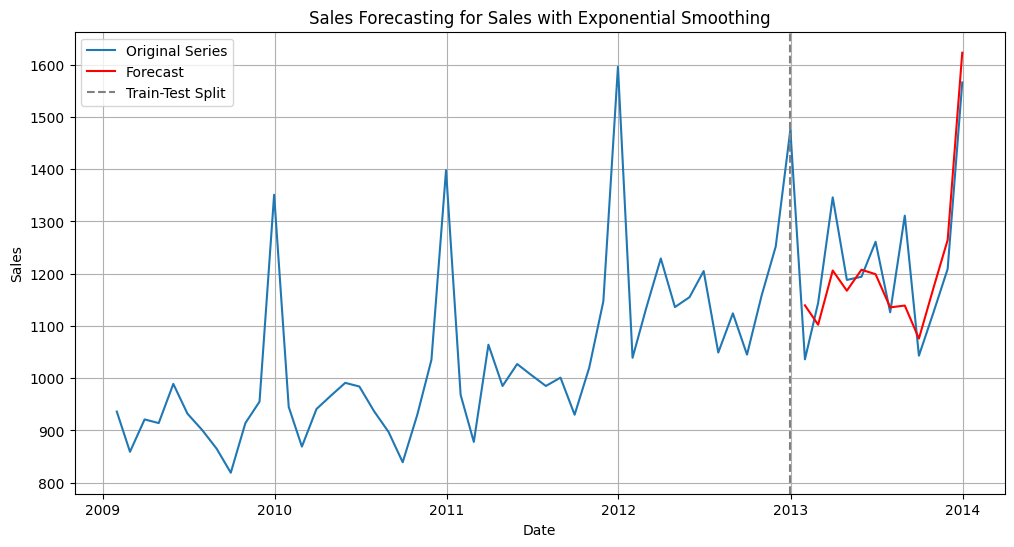

In [136]:
def run_exponential_smoothing(df, sales_column, seasonal_periods, trend, seasonal, title, train_ratio=0.8):
    # Train-test split
    train_size = int(len(df) * train_ratio)
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    
    # Fit Exponential Smoothing model on the sales column
    model = ExponentialSmoothing(train[sales_column], trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
    model_fit = model.fit(optimized=True)
    
    # Forecast
    n_forecasts = len(test)
    forecast = model_fit.forecast(steps=n_forecasts)
    forecast_index = test.index
    
    # Combine the original and forecasted values
    combined_df = pd.concat([train, test])
    combined_df['Forecast'] = np.nan
    combined_df.loc[forecast_index, 'Forecast'] = forecast.values
    
    # Ensure no NaN values in the forecasted period
    forecast_values = combined_df.loc[forecast_index, 'Forecast'].dropna()
    actual_values = test[sales_column].loc[forecast_values.index]
    
    # Calculate error metrics
    mae = mean_absolute_error(actual_values, forecast_values)
    mse = mean_squared_error(actual_values, forecast_values)
    mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100
    
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(combined_df.index, combined_df[sales_column], label='Original Series')
    plt.plot(combined_df.index, combined_df['Forecast'], label='Forecast', color='red')
    plt.axvline(x=train.index[-1], color='gray', linestyle='--', label='Train-Test Split')
    plt.legend()
    plt.title(f'Sales Forecasting for {title} with Exponential Smoothing')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid(True)
    plt.show()
    
    return combined_df


# Define the parameters
seasonal_periods = 12  
trend = 'add'  
seasonal = 'add'
title = 'Sales'

# Run the Exponential Smoothing model
# Run the Exponential Smoothing model
result_df_men = run_exponential_smoothing(df_men, 'Sales', seasonal_periods, trend, seasonal, title)
result_df_women = run_exponential_smoothing(df_women, 'Sales', seasonal_periods, trend, seasonal, title)
result_df_other = run_exponential_smoothing(df_other, 'Sales', seasonal_periods, trend, seasonal, title)

## Prophet Model

16:33:32 - cmdstanpy - INFO - Chain [1] start processing
16:33:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 30.85832646031484
Mean Squared Error (MSE): 1305.226941903856
Mean Absolute Percentage Error (MAPE): 4.42%


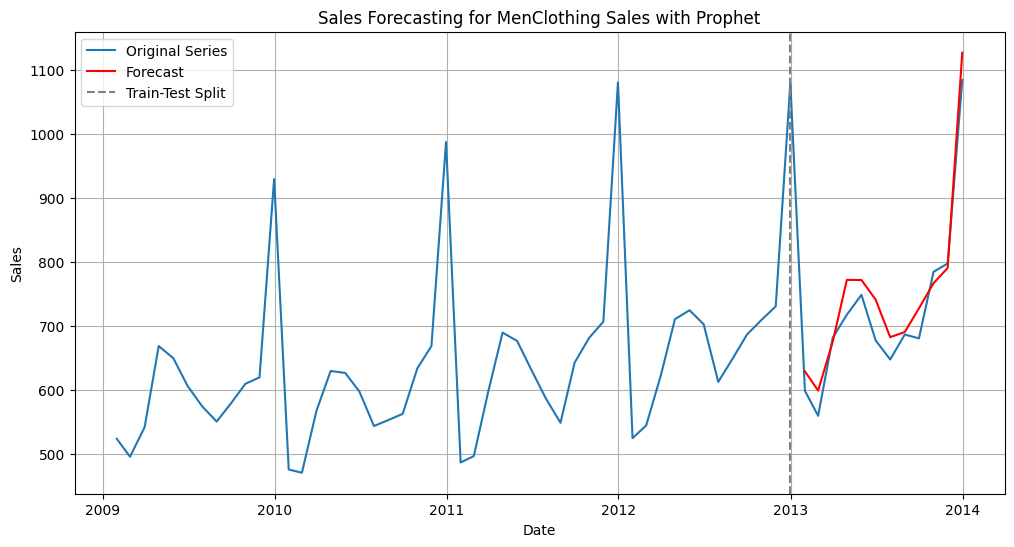

16:33:34 - cmdstanpy - INFO - Chain [1] start processing
16:33:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 178.5960531000003
Mean Squared Error (MSE): 60450.14565260947
Mean Absolute Percentage Error (MAPE): 5.68%


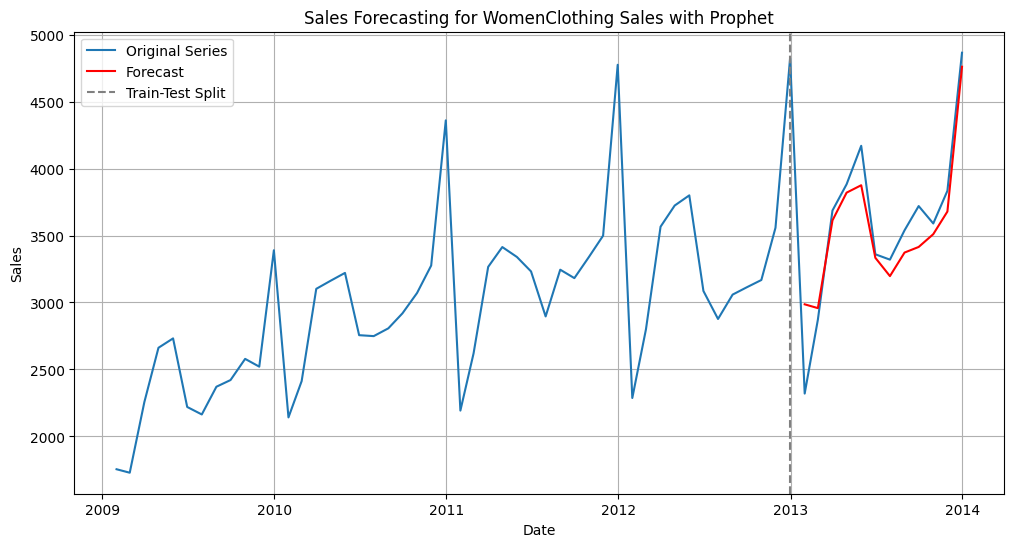

16:33:34 - cmdstanpy - INFO - Chain [1] start processing
16:33:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 99.81426736682899
Mean Squared Error (MSE): 12514.434470529444
Mean Absolute Percentage Error (MAPE): 8.49%


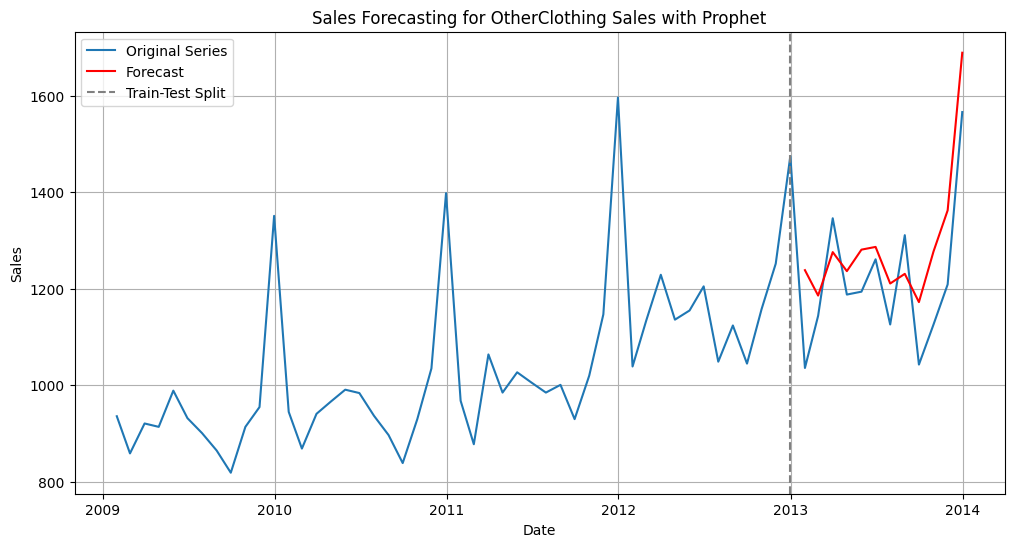

In [146]:
def run_prophet_forecasting(df, sales_column, title, train_ratio=0.8):
    # Train-test split
    train_size = int(len(df) * train_ratio)
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    
    # Prepare data for Prophet
    train_prophet = train.reset_index().rename(columns={'Date': 'ds', sales_column: 'y'})
    test_prophet = test.reset_index().rename(columns={'Date': 'ds', sales_column: 'y'})
    
    # Fit Prophet model
    model = Prophet()
    model.fit(train_prophet)
    
    # Forecast
    future = model.make_future_dataframe(periods=len(test), freq='M')
    forecast = model.predict(future)
    
    # Extract forecasted values
    forecast_values = forecast[['ds', 'yhat']].set_index('ds').loc[test.index]['yhat']
    
    # Combine the original and forecasted values
    combined_df = pd.concat([train, test])
    combined_df['Forecast'] = np.nan
    combined_df.loc[test.index, 'Forecast'] = forecast_values.values
    
    # Ensure no NaN values in the forecasted period
    forecast_values = combined_df.loc[test.index, 'Forecast'].dropna()
    actual_values = test[sales_column].loc[forecast_values.index]
    
    # Calculate error metrics
    mae = mean_absolute_error(actual_values, forecast_values)
    mse = mean_squared_error(actual_values, forecast_values)
    mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100
    
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(combined_df.index, combined_df[sales_column], label='Original Series')
    plt.plot(combined_df.index, combined_df['Forecast'], label='Forecast', color='red')
    plt.axvline(x=train.index[-1], color='gray', linestyle='--', label='Train-Test Split')
    plt.legend()
    plt.title(f'Sales Forecasting for {title} with Prophet')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid(True)
    plt.show()
    
    return combined_df


# Define the parameters
title_men = 'MenClothing Sales'
title_women = 'WomenClothing Sales'
title_other = 'OtherClothing Sales'

# Run the Prophet model
result_df_men = run_prophet_forecasting(df_men, 'Sales', title_men)
result_df_women = run_prophet_forecasting(df_women, 'Sales', title_women)
result_df_other = run_prophet_forecasting(df_other, 'Sales', title_other)
